In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import ast
import joblib

In [9]:
# Replace with the path to your cleaned CSV file
data_file = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Cleaned Graph Data/parsed_probe_data.csv'

# Load the data
df = pd.read_csv(data_file)

# Display the first few rows
print(df.head())

# # Replace 'natural_move_one' and 'natural_move_three' with 'natural_movie' to merge categories
# df['presentation_type'] = df['presentation_type'].replace({
#     'natural_move_one': 'natural_movie',
#     'natural_move_three': 'natural_movie'
# })

print(df['presentation_type'].unique())

        probe_name visual_area presentation_type  interval_start  \
0  probe_773463015       VISam           flashes               1   
1  probe_773463015       VISam           flashes              51   
2  probe_773463015       VISam           flashes             101   
3  probe_773463015       VISam           flashes             151   
4  probe_773463015       VISam   static_gratings               1   

   interval_end   max_phi max_phi_state  total_distinctions  \
0            50  4.504989     [1, 1, 1]                   7   
1           100  3.755319     [0, 0, 0]                   7   
2           150  3.590710     [1, 1, 1]                   7   
3           200  3.444718     [0, 0, 1]                   7   
4            50  3.429473     [1, 0, 0]                   7   

   total_integrated_information_distinctions  total_cause_information  \
0                                   1.766300                 4.503652   
1                                   1.637070                 4.328

In [10]:
print(df.columns)
print(df.dtypes)
print(df.isnull().sum())

Index(['probe_name', 'visual_area', 'presentation_type', 'interval_start',
       'interval_end', 'max_phi', 'max_phi_state', 'total_distinctions',
       'total_integrated_information_distinctions', 'total_cause_information',
       'total_effect_information', 'total_relations',
       'total_integrated_information_relations', 'faces_1_9', 'faces_10_30',
       'faces_30_plus'],
      dtype='object')
probe_name                                    object
visual_area                                   object
presentation_type                             object
interval_start                                 int64
interval_end                                   int64
max_phi                                      float64
max_phi_state                                 object
total_distinctions                             int64
total_integrated_information_distinctions    float64
total_cause_information                      float64
total_effect_information                     float64
total_relati

In [11]:
# Convert string representation of lists into actual lists
df['max_phi_state'] = df['max_phi_state'].apply(ast.literal_eval)

# Since it's a list of integers, we can expand it into multiple columns
max_phi_state_df = df['max_phi_state'].apply(pd.Series)
max_phi_state_df.columns = ['max_phi_state_1', 'max_phi_state_2', 'max_phi_state_3']

# Drop the original 'max_phi_state' column and concatenate the new columns
df = pd.concat([df.drop('max_phi_state', axis=1), max_phi_state_df], axis=1)

In [12]:
# Use LabelEncoder for 'visual_area'
le_visual_area = LabelEncoder()
df['visual_area_encoded'] = le_visual_area.fit_transform(df['visual_area'])

# Optionally, drop the original 'visual_area' column
df = df.drop('visual_area', axis=1)

In [13]:
le_presentation_type = LabelEncoder()
df['presentation_type_encoded'] = le_presentation_type.fit_transform(df['presentation_type'])
# Get class names for future reference
class_names = le_presentation_type.classes_

# Print the mapping of classes to encoded labels
label_mapping = dict(zip(le_presentation_type.classes_, le_presentation_type.transform(le_presentation_type.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'flashes': np.int64(0), 'gabors': np.int64(1), 'natural_move_one': np.int64(2), 'natural_move_three': np.int64(3), 'natural_scenes': np.int64(4), 'static_gratings': np.int64(5)}


In [14]:
# Define feature columns
feature_cols = [
    'interval_start', 'interval_end', 'max_phi',
    'total_distinctions', 'total_integrated_information_distinctions',
    'total_cause_information', 'total_effect_information', 'total_relations',
    'total_integrated_information_relations', 'faces_1_9', 'faces_10_30',
    'faces_30_plus', 'visual_area_encoded',
    'max_phi_state_1', 'max_phi_state_2', 'max_phi_state_3'
]

# Define X and y
X = df[feature_cols]
y = df['presentation_type_encoded']

In [15]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [55]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
# Updated parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # Removed 'auto'
    'bootstrap': [True, False]
}

# Base model
rf = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Best model
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estim

In [56]:
import joblib

# Save the best model
folder = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/'
model_filename = 'best_random_forest_model_merged_movies.pkl'
joblib.dump(best_rf, folder + model_filename)

['/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/best_random_forest_model_merged_movies.pkl']

In [16]:
# load the model
folder = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/'
model_filename = 'best_random_forest_model.pkl'
loaded_model = joblib.load(folder + model_filename)

In [28]:
# Access hyperparameters
best_params = loaded_model.get_params()
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [21]:
# Evaluate the best model
y_pred = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))
importances = loaded_model.feature_importances_

                    precision    recall  f1-score   support

           flashes       0.76      0.55      0.64       228
            gabors       0.36      0.24      0.28       228
  natural_move_one       0.32      0.25      0.28       228
natural_move_three       0.41      0.78      0.54       228
    natural_scenes       0.30      0.32      0.31       228
   static_gratings       0.49      0.45      0.47       228

          accuracy                           0.43      1368
         macro avg       0.44      0.43      0.42      1368
      weighted avg       0.44      0.43      0.42      1368



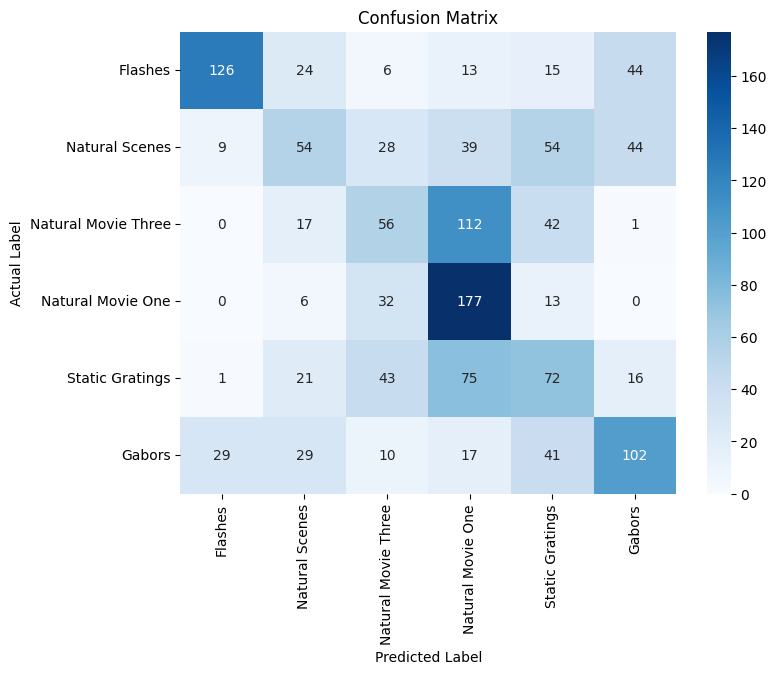

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class names
class_names = le_presentation_type.classes_

# clean up the class names by capitalizing and replacing underscores with spaces
class_names = {'Flashes', 'Gabors', 'Natural Movie One', 'Natural Movie Three', 'Natural Scenes', 'Static Gratings'}

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


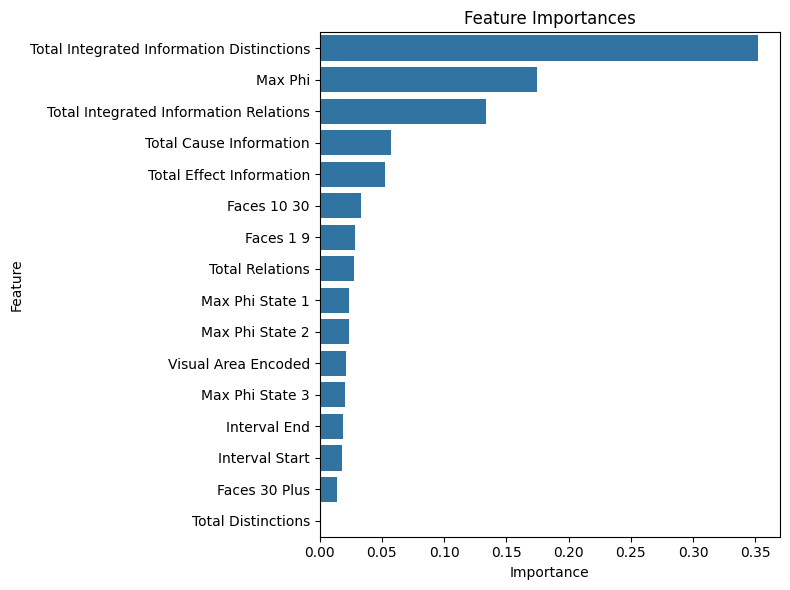

In [32]:
import pandas as pd

# Get feature importances from the best model
# importances = best_rf.feature_importances_

# Create a DataFrame for visualization
feature_names = X_train.columns
# clean up the feature names by replacing underscores with spaces and capitalizing
feature_names = [name.replace('_', ' ').title() for name in feature_names]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


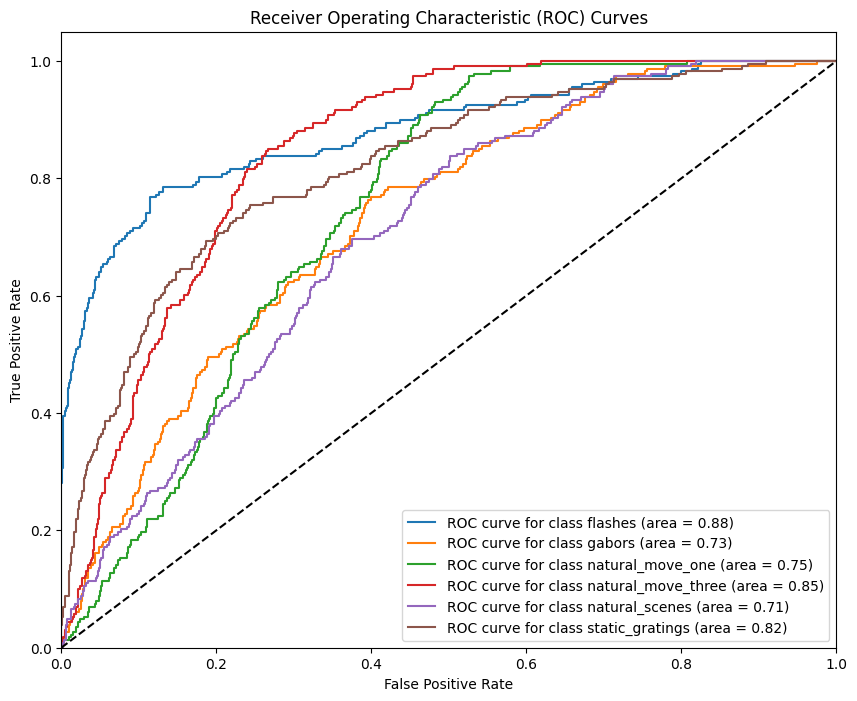

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=loaded_model.classes_)
n_classes = y_test_binarized.shape[1]

# Fit the model with OneVsRestClassifier
classifier = OneVsRestClassifier(loaded_model)
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [48]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import dataframe_image as dfi

# After grid search and obtaining best_rf

# Evaluate the best model
y_pred = loaded_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_presentation_type.classes_))

# Generate the classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=le_presentation_type.classes_, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Select only class-specific rows and macro avg row
report_df = report_df.loc[list(le_presentation_type.classes_) + ['macro avg']]

# Style and display the table
styled_report = report_df.style.format(precision=2).set_caption("Classification Report with Macro Average").background_gradient(cmap="Blues", subset=['precision', 'recall', 'f1-score'])
display(styled_report)
folder = '/Users/paxpoggi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Maier Lab/IIT Notebooks/Models/'
dfi.export(styled_report, folder + "classification_report_random_forest.png")

# Drop unnecessary rows
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Add per-class accuracy to the DataFrame
report_df['accuracy'] = per_class_accuracy

# Reset index to get the class names as a column
report_df.reset_index(inplace=True)

# Rename the columns
report_df.rename(columns={'index': 'Class', 'precision': 'Precision', 'recall': 'Recall',
                          'f1-score': 'F1-Score', 'support': 'Support', 'accuracy': 'Accuracy'}, inplace=True)

# Reorder the columns
report_df = report_df[['Class', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']]

# Format the numeric values to 4 decimal places
report_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = report_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].round(4)

# Display the DataFrame
print("\nPer-Class Metrics:")
print(report_df.to_string(index=False))


Classification Report:
                    precision    recall  f1-score   support

           flashes       0.76      0.55      0.64       228
            gabors       0.36      0.24      0.28       228
  natural_move_one       0.32      0.25      0.28       228
natural_move_three       0.41      0.78      0.54       228
    natural_scenes       0.30      0.32      0.31       228
   static_gratings       0.49      0.45      0.47       228

          accuracy                           0.43      1368
         macro avg       0.44      0.43      0.42      1368
      weighted avg       0.44      0.43      0.42      1368



,precision,recall,f1-score,support
flashes,0.76,0.55,0.64,228.00
gabors,0.36,0.24,0.28,228.00
natural_move_one,0.32,0.25,0.28,228.00
natural_move_three,0.41,0.78,0.54,228.00
natural_scenes,0.30,0.32,0.31,228.00
static_gratings,0.49,0.45,0.47,228.00
macro avg,0.44,0.43,0.42,1368.00



Per-Class Metrics:
             Class  Accuracy  Precision  Recall  F1-Score  Support
           flashes    0.5526     0.7636  0.5526    0.6412    228.0
            gabors    0.2368     0.3576  0.2368    0.2850    228.0
  natural_move_one    0.2456     0.3200  0.2456    0.2779    228.0
natural_move_three    0.7763     0.4088  0.7763    0.5356    228.0
    natural_scenes    0.3158     0.3038  0.3158    0.3097    228.0
   static_gratings    0.4474     0.4928  0.4474    0.4690    228.0


In [46]:
from tabulate import tabulate
# Print the table
print(tabulate(report_df, headers='keys', tablefmt='psql', showindex=False))
# print classification report


+--------------------+------------+-------------+----------+------------+-----------+
| Class              |   Accuracy |   Precision |   Recall |   F1-Score |   Support |
|--------------------+------------+-------------+----------+------------+-----------|
| flashes            |     0.5526 |      0.7636 |   0.5526 |     0.6412 |       228 |
| gabors             |     0.2368 |      0.3576 |   0.2368 |     0.285  |       228 |
| natural_move_one   |     0.2456 |      0.32   |   0.2456 |     0.2779 |       228 |
| natural_move_three |     0.7763 |      0.4088 |   0.7763 |     0.5356 |       228 |
| natural_scenes     |     0.3158 |      0.3038 |   0.3158 |     0.3097 |       228 |
| static_gratings    |     0.4474 |      0.4928 |   0.4474 |     0.469  |       228 |
+--------------------+------------+-------------+----------+------------+-----------+
